In [2]:
# Import lib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client
import warnings
import time
import glob
import seaborn as sns
import dask
import geopandas as gpd
import rasterio.mask
from shapely.geometry import mapping
import rioxarray
from rasterio import features
from affine import Affine
from pyhdf.SD import SD, SDC

warnings.filterwarnings("ignore")

plt.style.use('ggplot')

# LOAD INSAT AND MODIS DATASET

In [1]:
# TESTING ON ACTUAL DATA
#Loading AOD Dataset for testing 
aod_file = glob.glob('./Data/AOD/*')
aod_insat3D = glob.glob(aod_file[3]+'/*')
aod_insat3DR = glob.glob(aod_file[4]+'/*')
ds_3DR = xr.open_mfdataset(aod_insat3DR)
ds_3D = xr.open_mfdataset(aod_insat3D)

# #slicing
ds1_3DR = ds_3DR.sel(time=slice('2017-01-01','2017-01-31'),latitude=slice(39,8),longitude=slice(67,99)).load()
ds1_3D = ds_3D.sel(time=slice('2017-01-01','2017-01-31'),latitude=slice(39,8),longitude=slice(67,99)).load()

# merging
ds_insat = xr.concat([ds1_3DR, ds1_3D], dim='time').sortby('time')
print(aod_file)

NameError: name 'glob' is not defined

In [25]:
ds_insat

<xarray.Dataset>
Dimensions:    (time: 8969, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2017-01-01T05:30:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [26]:
ds1_3D

<xarray.Dataset>
Dimensions:    (time: 4269, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2017-01-01T05:30:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3DIMG_01J...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3DIMG_01J...
    Satellite_Name:                                                 INSAT-3D
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [28]:
ds1_3DR

<xarray.Dataset>
Dimensions:    (time: 4700, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2017-01-01T05:45:00 ... 2018-12-31T08:15:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

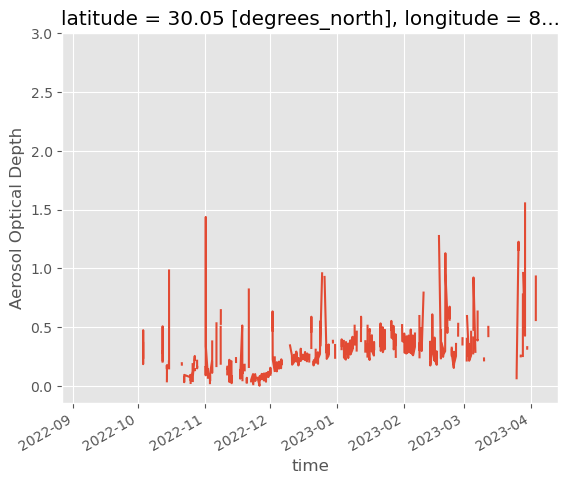

In [3]:
ds_3DR.AOD.sel(latitude=30,longitude=80,method='nearest').plot()

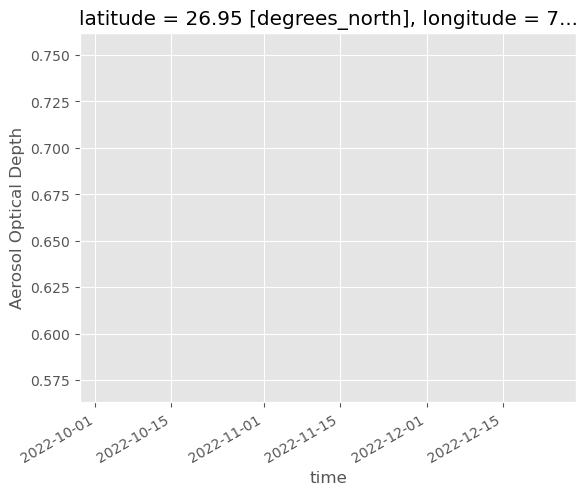

In [5]:
ds_3DR.AOD.sel(latitude=26.95,longitude=75.85,method='nearest').plot()

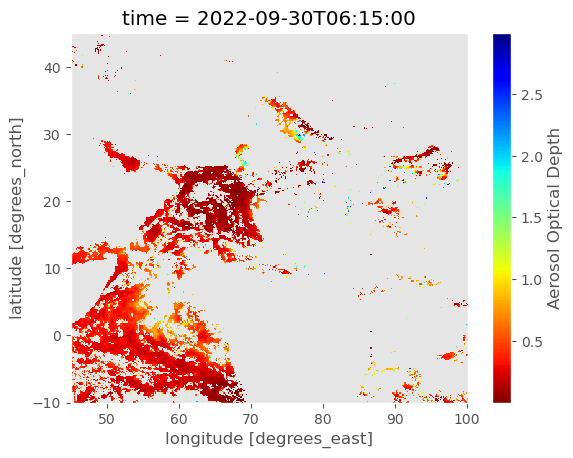

In [8]:
ds_3DR.AOD.isel(time=200).plot(cmap='jet_r')

In [45]:
(ds_3DR.AOD.count().load().values/(ds_3DR.dims['time']*ds_3DR.dims['latitude']*ds_3DR.dims['longitude']))*100

24.137325681686537

In [46]:
(ds_3D.AOD.count().load().values/(ds_3DR.dims['time']*ds_3DR.dims['latitude']*ds_3DR.dims['longitude']))*100

28.379046135270585

In [3]:
aod_modis_dir = glob.glob(aod_file[3]+'/*')
# MODIS DIR contain sub folder with no time dimension
# Create empty list to store file path with time stamp
aod_modis_path = []
time_stamp = []

# Mention Starting Year
for year in aod_modis_dir:
        
    start_year = np.datetime64(year.split('_')[-1])
    for path in glob.glob(year+'/*'):
        aod_modis_path.append(glob.glob(path+'/*'))
        day_no  = int(path.split('\\')[-1]) # Day number according to file name i,e 001,002,003,...365
        time_stamp.append(start_year + np.timedelta64(day_no-1, 'D')) # add timestamp to that particular file index

aod_modis_path[0],time_stamp[0]

(['./Data/AOD\\MODIS\\MODIS_2017\\001\\MOD08_D3.A2017001.061.2017316211803.hdf'],
 numpy.datetime64('2017-01-01'))

In [4]:
# Declare Datafield Name
DATAFIELD_NAME = 'AOD_550_Dark_Target_Deep_Blue_Combined_Mean'

# Temporary list to store data to make xarray dataset
DATA = []
TIME = []
LAT = []
LON = []

# Read MODIS file
for idx, FILE_NAME in  enumerate(aod_modis_path):
        
    hdf = SD(*FILE_NAME, SDC.READ)
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)
    
    # Read dataset.
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)

    # Read lat/lon.
    xdim = hdf.select('XDim')
    lon = xdim[:].astype(np.double)

    ydim = hdf.select('YDim')
    lat = ydim[:].astype(np.double)
    
    # Retrieve attributes.
    attrs = data_raw.attributes(full=1)
    lna=attrs["long_name"]
    long_name = lna[0]
    aoa=attrs["add_offset"]
    add_offset = aoa[0]
    fva=attrs["_FillValue"]
    _FillValue = fva[0]
    sfa=attrs["scale_factor"]
    scale_factor = sfa[0]        
    ua=attrs["units"]
    units = ua[0]

    # Fill 9999 with NaN value
    data[data == _FillValue] = np.nan
    data =  scale_factor * (data - add_offset) 
    datam = np.ma.masked_array(data, np.isnan(data))
    
    # Store result in DATA and TIME list
    TIME.append(time_stamp[idx])
    DATA.append(data)
    

# Make np array for list
TIME = np.array(TIME)
LAT = np.array(lat)
LON = np.array(lon)
DATA = np.array(DATA)

print("Data file is ready !!!")

Data file is ready !!!


In [5]:
# Create Modis Dataset
ds_modis = xr.Dataset(
        {
            'AOD': (['time','latitude', 'longitude'], DATA),
            'time': (['time'],TIME),
            'latitude': (['latitude'], LAT),
            'longitude': (['longitude'], LON),
        }
    )


ds_modis = ds_modis.sel(latitude=slice(39,8),longitude=slice(67,98))

In [6]:
ds_insat

<xarray.Dataset>
Dimensions:    (time: 8969, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2017-01-01T05:30:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [7]:
ds_modis

<xarray.Dataset>
Dimensions:    (time: 730, latitude: 31, longitude: 31)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2018-12-31
  * latitude   (latitude) float64 38.5 37.5 36.5 35.5 34.5 ... 11.5 10.5 9.5 8.5
  * longitude  (longitude) float64 67.5 68.5 69.5 70.5 ... 94.5 95.5 96.5 97.5
Data variables:
    AOD        (time, latitude, longitude) float64 nan nan nan ... 0.126 0.113

In [10]:
def read_aeronet_data(path):  
    df_temp = pd.read_csv(path,sep='\t',skiprows=[0])
    
    #Get lat and lon
    lat_loc,lon_loc = df_temp['Site_Latitude(Degrees)'].unique(), df_temp['Site_Longitude(Degrees)'].unique()
      
    
    # Taking only date and aod column
    df_temp = df_temp[['Date(dd:mm:yyyy)','AOD_675nm',]]
    
    df_temp['Date'] = pd.to_datetime(df_temp['Date(dd:mm:yyyy)'], format='%d:%m:%Y')
    df_temp = df_temp.drop(columns=['Date(dd:mm:yyyy)'])
    df_temp = df_temp.replace(-999, np.nan)
    df_temp = df_temp.sort_values(by='Date')
    
    return df_temp,lat_loc,lon_loc

In [17]:
# AERONET DATASET
aeronet_dataset = glob.glob(aod_file[2]+'/*')
# LOAD AERONET DATASET

jaipur_path = str(glob.glob(aeronet_dataset[2]+'/*')[0])
kanpur_path = str(glob.glob(aeronet_dataset[3]+'/*')[0])
print(aeronet_dataset)

df,lat_loc,lon_loc = read_aeronet_data(kanpur_path)
print(df.head())
print(lat_loc,lon_loc)

['./Data/AOD\\Aeronet\\20170101_20181231_Amity_Univ_Gurgaon', './Data/AOD\\Aeronet\\20170101_20181231_Gandhi_College', './Data/AOD\\Aeronet\\20170101_20181231_Jaipur', './Data/AOD\\Aeronet\\20170101_20181231_Kanpur', './Data/AOD\\Aeronet\\aeronet_excel']
   AOD_675nm       Date
0   1.058814 2017-01-01
1   1.177943 2017-01-03
2   0.364626 2017-01-04
3   0.762151 2017-01-05
4   0.591533 2017-01-06
[26.512778] [80.231639]


## INSAT(hourly) RAW VS MODIS(daily) RAW VS AERONET (daily)

In [25]:
# CONVERT DAILY DATAFRAME TO MONTLY DATAFRAME
def convert_date(df,f = 'M'):
    # set 'Date' column as the index
    temp = df.set_index('Date')

    # group data by month and calculate the mean 'AOD' value
    monthly_data = temp.groupby(pd.Grouper(freq=f)).mean()
    # reset the index to include the 'Date' column

    monthly_data = monthly_data.reset_index()

    return monthly_data


In [15]:
df

,AOD_675nm,Date
0,0.400807,2017-01-02
1,0.498103,2017-01-02
2,0.466878,2017-01-02
3,0.483949,2017-01-02
16,0.369327,2017-01-03
...,...,...
4792,0.028150,2017-12-18
4793,0.031046,2017-12-18
4794,0.035140,2017-12-18
4785,0.025706,2017-12-18


In [31]:
def time_series_plot(ds1,ds2,df,place,LAT,LON,title):
    
    ds1 = ds1.sel(latitude=LAT,longitude=LON,method='nearest')
    ds2 = ds2.sel(latitude=LAT,longitude=LON,method='nearest')
    
    print(f"AERONET {place} and lat:{LAT},lon:{LON}")
    print(f"Insat and lat:{ds1.latitude.values},lon:{ds1.longitude.values}")
    print(f"Modis and lat:{ds2.latitude.values},lon:{ds2.longitude.values}")
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 3))

    # Plot the Aeronet dataframe
    ax.plot(df['Date'], df['AOD_675nm'], linewidth=1, label='Aeronet',color='black')

    
    
    # Plot the Insat dataframe
    ds1.AOD.plot(ax=ax,label='Insat Combined', color='blue',alpha=0.5)
    
    # Plot the third dataframe
    ds2.AOD.plot(ax=ax,label='Insat 3D', color='yellow',alpha=0.5)
    
    # Add legend, title, and axis labels
    ax.legend()
    ax.set_title(f'{place}, {title}', fontweight='bold')
    ax.set_xlabel('Time')
    ax.set_ylabel('AOD')
    #ax.set_xlim(pd.Timestamp('2022-08-01'), pd.Timestamp('2023-04-01'))
    #ax.set_ylim(0,2)
    
    # Show the plot
    plt.show()


AERONET Jaipur and lat:[26.905817],lon:[75.806217]
Insat and lat:[26.95],lon:[75.85]
Modis and lat:[26.95],lon:[75.85]


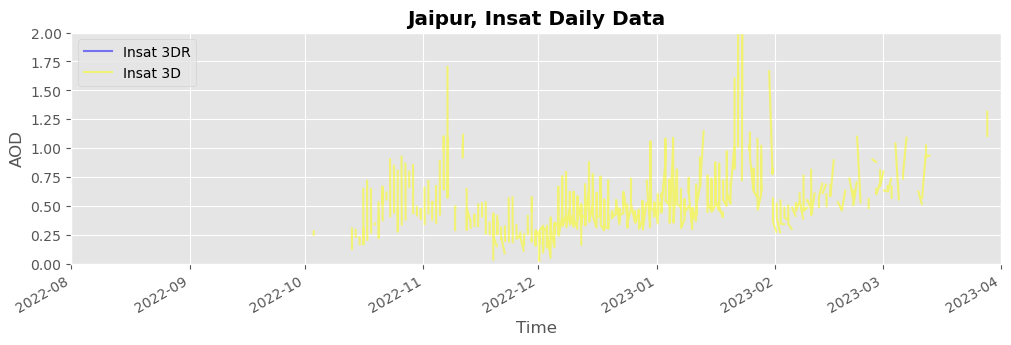

In [29]:
time_series_plot(ds_3DR,ds_3D,df,'Jaipur',lat_loc,lon_loc,title='Insat Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon


AERONET kanpur and lat:[26.512778],lon:[80.231639]
Insat and lat:[26.55],lon:[80.25]
Modis and lat:[26.55],lon:[80.25]


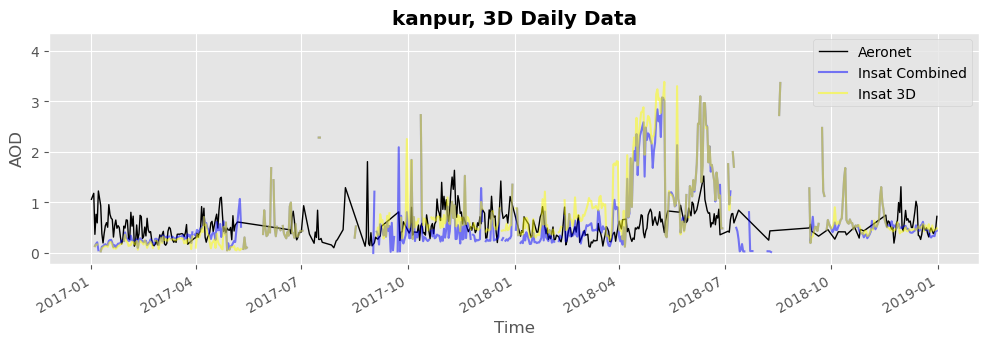

AERONET kanpur and lat:[26.512778],lon:[80.231639]
Insat and lat:[26.55],lon:[80.25]
Modis and lat:[26.55],lon:[80.25]


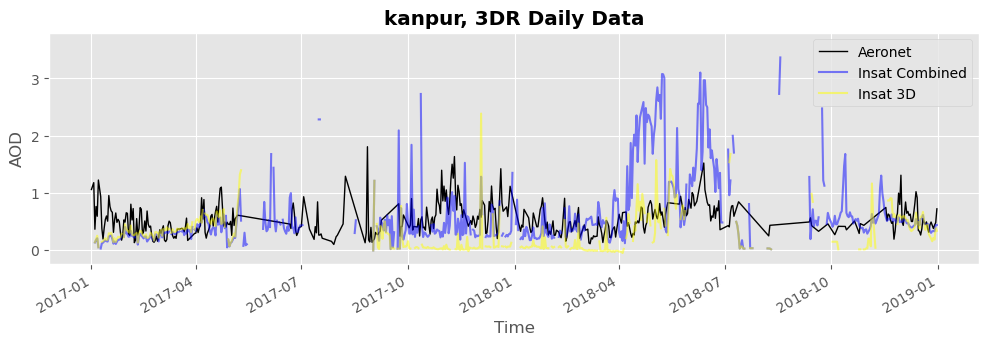

In [32]:
# INSAT half hourly, modis daily and aeronet daily 
time_series_plot(ds_insat.resample(time='1D').mean(),ds1_3D.resample(time='1D').mean(),df,'kanpur',lat_loc,lon_loc,title='3D Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon
time_series_plot(ds_insat.resample(time='1D').mean(),ds1_3DR.resample(time='1D').mean(),df,'kanpur',lat_loc,lon_loc,title='3DR Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon

In [22]:
# INSAT half hourly, modis daily and aeronet daily 
time_series_plot(ds_insat.resample(time='1D').mean(),ds_modis,df,'Jaipur',lat_loc,lon_loc,title='Combined Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon
time_series_plot(ds1_3D.resample(time='1D').mean(),ds_modis,df,'jaipur',lat_loc,lon_loc,title='3D Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon
time_series_plot(ds1_3DR.resample(time='1D').mean(),ds_modis,df,'jaipur',lat_loc,lon_loc,title='3DR Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon

NameError: name 'ds_modis' is not defined

In [ ]:
# INSAT half hourly, modis daily and aeronet daily 
time_series_plot(ds_insat.resample(time='1D').mean(),ds_modis,df,'Kanpur',lat_loc,lon_loc,title='Combined Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon
time_series_plot(ds1_3D.resample(time='1D').mean(),ds_modis,df,'Kanpur',lat_loc,lon_loc,title='3D Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon
time_series_plot(ds1_3DR.resample(time='1D').mean(),ds_modis,df,'Kanpur',lat_loc,lon_loc,title='3DR Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon

In [ ]:
#ds_modis,ds_insat,df

In [ ]:
# FILTER

# 2-sigma rule filter
def twoSig_pos_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean + 1*std
    return res.where(count>=3)

def twoSig_neg_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean - 1*std
    return res.where(count>=3)

def twoSigfilter(ds):
   
    # Converting hourly to daily timestamp
    daily_timestamp = ds.time.dt.floor('1D')
    unique_day = np.unique(daily_timestamp)
    
    # COUNT PLOT ON TIME DIMENSION
    ds_day_count = ds.groupby(daily_timestamp).count(dim='time').rename({'floor':'time'})

    # Calculating mean + 1*sigma
    ds_twoSig_pos= ds.groupby(daily_timestamp).apply(twoSig_pos_rule).rename({'floor': 'time'})

    # Calculating mean - 1*sigma
    ds_twoSig_neg= ds.groupby(daily_timestamp).apply(twoSig_neg_rule).rename({'floor': 'time'})

    # re-arrange coordinates
    ds_twoSig_pos = ds_twoSig_pos[['time','latitude','longitude','AOD']]
    ds_twoSig_neg = ds_twoSig_neg[['time','latitude','longitude','AOD']]

    # Assigning Time Coordinate value as data_set timestamp since it is 0,1,..365 format
    
    print(len(ds_day_count.time.values))
    ds_twoSig_pos.coords['time'] = unique_day
    ds_twoSig_neg.coords['time'] = unique_day
    
    # Flooring hourly time to day time and generate duplicate time index for same hour
    ds.coords['time'] = ds.time.dt.floor('1D')

    # Create a mask for filtering out the data
    mask = (ds['AOD'] < ds_twoSig_pos.sel(time=ds['time'])) & (ds['AOD'] > ds_twoSig_neg.sel(time=ds['time']))

    # Apply the mask to filter out the data
    filtered_data = ds.where(mask)
    
    return filtered_data

In [ ]:
ds_combined_filter = twoSigfilter(ds_insat)
ds_3D_filter = twoSigfilter(ds1_3D)
ds_3DR_filter = twoSigfilter(ds1_3DR)

In [ ]:
# INSAT half hourly, modis daily and aeronet daily 
time_series_plot(ds_combined_filter.resample(time='1D').mean(),ds_modis,df,'Kanpur',lat_loc,lon_loc,title='Combined Daily Filter Data') # INSAT,MODIS,Aeronet,place,lat,lon
time_series_plot(ds_3D_filter.resample(time='1D').mean(),ds_modis,df,'Kanpur',lat_loc,lon_loc,title='3D Daily Filter Data') # INSAT,MODIS,Aeronet,place,lat,lon
time_series_plot(ds_3DR_filter.resample(time='1D').mean(),ds_modis,df,'Kanpur',lat_loc,lon_loc,title='3DR Daily Filter Data') # INSAT,MODIS,Aeronet,place,lat,lon

In [ ]:
# INSAT half hourly, modis daily and aeronet daily 
time_series_plot(ds_insat.resample(time='1D').mean(dim='time'),ds_modis,df,'Kanpur',lat_loc,lon_loc,title='Daily Data') # INSAT,MODIS,Aeronet,place,lat,lon
time_series_plot(ds_insat_filter.resample(time='1D').mean(dim='time'),ds_modis,df,'Kanpur',lat_loc,lon_loc,title='Daily Filter Data') # INSAT,MODIS,Aeronet,place,lat,lon

In [ ]:
# Regridding 
def regrid_1(ds,res):
    minx = ds.longitude.min().item()
    maxx = ds.longitude.max().item()
    miny = ds.latitude.min().item()
    maxy = ds.latitude.max().item()


    out_res = res
    interval_window = out_res/2
    # set up new lat/lon grid
    new_grid_x = np.arange(
        np.ceil(minx / out_res) * out_res,
        (np.floor(maxx / out_res) + 0.5) * out_res,
        out_res
    )
    new_grid_y = np.arange(
        np.ceil(miny / out_res) * out_res,
        (np.floor(maxy / out_res) + 0.5) * out_res,
        out_res
    )
    
    
    return ds.interp(longitude=new_grid_x[:] + interval_window, latitude=new_grid_y[:] + interval_window, method="nearest")

def regrid_2(ds,thres,res):

    out_res = res
    minx = ds.longitude.min().item()
    maxx = ds.longitude.max().item()
    miny = ds.latitude.min().item()
    maxy = ds.latitude.max().item()

    lat = 'latitude'
    lon = 'longitude'
    
    interval_window = out_res/2
    new_grid_y = np.arange(miny-interval_window, maxy+out_res, out_res) # Latitude label
    new_grid_x = np.arange(minx-interval_window, maxx+out_res, out_res) # longitude Label

    #print(new_grid_x,new_grid_y)
    gb1 = ds.groupby_bins(lon, bins=new_grid_x).apply(
        lambda x: x.groupby_bins(lat,bins=new_grid_y).apply(
            lambda y:  y.groupby('time').mean(dim=[lat,lon]).where((
                            y.groupby('time').count(dim=[lat, lon])/(y.groupby('time').count(dim=[lat, lon]) + y.groupby('time').apply(
                            lambda z: z.isnull().sum(dim=[lat, lon])))
                        ) >= thres,np.nan) 
            )
        )

    gb = gb1.rename({lon+"_bins":lon,lat+"_bins":lat})
    gb[lat] = new_grid_y[:-1] + interval_window
    gb[lon] = new_grid_x[:-1] + interval_window
    
    return gb


In [ ]:
# correlation plot
def corr_plot(ds1,ds2):
    ds1 = ds1_3DR.resample(time='1D').mean()
    ds2 = ds1_3D.resample(time='1D').mean()


    corr = xr.corr(ds1.AOD, ds2.AOD, dim='time')

    # plot correlation
    corr.plot()
    plt.show()
corr_plot(ds1_3D,ds1_3DR)

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))

ds1 = ds1_3D.sel(latitude=lat_loc,longitude=lon_loc,method='nearest')
ds2 = ds1_3DR.sel(latitude=lat_loc,longitude=lon_loc,method='nearest')
ds3 = ds_insat.sel(latitude=lat_loc,longitude=lon_loc,method='nearest')

mean_3D = ds1.resample(time='1D').mean()
mean_3DR = ds2.resample(time='1D').mean()
mean_merged = ds3.resample(time='1D').mean()


mean_3D.AOD.sel(latitude=lat_loc,longitude=lon_loc,method='nearest').plot(ax=ax,label='3D',color='red',alpha=0.4)
mean_3DR.AOD.sel(latitude=lat_loc,longitude=lon_loc,method='nearest').plot(ax=ax,label='3DR',color='blue',alpha=0.4)
mean_merged.AOD.sel(latitude=lat_loc,longitude=lon_loc,method='nearest').plot(ax=ax,label='merged',color='black')

ax.legend()
ax.set_ylim()
plt.style.use('ggplot')
plt.show()